#### Имеются данные о пользователях интернет-магазина. Необходимо провести анализ и дать ответы на вопросы:<br>
- 1. Сколько имеется пользователей, которые совершили покупку только один раз? 
- 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 
- 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 
- 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?  
- 5. Провести когортный анализ пользователей, в период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.
- 6. Провести RFM-сегментацию пользователей 


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import requests
from urllib.parse import urlencode
%matplotlib inline
from datetime import datetime, timedelta

In [2]:
# исходные данные olist_customers_dataset.csv

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

customers = pd.read_csv(download_url) #исходный датафрэйм с информацией о пользователях

In [3]:
# исходные данные olist_order_items_dataset.csv

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

items = pd.read_csv(download_url) #исходный датафрэйм с информацией о товарах, входящих в заказ

In [4]:
# исходные данные olist_orders_dataset.csv

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

orders = pd.read_csv(download_url) #исходный датафрэйм с информацией о заказах

Описание данных:<br>
**orders** - таблица заказов
- order_id —  уникальный идентификатор заказа (номер чека)
- customer_id —  позаказный идентификатор пользователя
- order_status —  статус заказа
- order_purchase_timestamp —  время создания заказа
- order_approved_at —  время подтверждения оплаты заказа
- order_delivered_carrier_date —  время передачи заказа в логистическую службу
- order_delivered_customer_date —  время доставки заказа
- order_estimated_delivery_date —  обещанная дата доставки

**items** - товарные позиции, входящие в заказы
- order_id —  уникальный идентификатор заказа (номер чека)
- order_item_id —  идентификатор товара внутри одного заказа
- product_id —  идентификатор-аналог штрихкода товара
- seller_id — идентификатор производителя товара
- shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
- price —  цена за единицу товара
- freight_value —  вес товара

**customers** - таблица с уникальными идентификаторами пользователей
- customer_id — позаказный идентификатор пользователя
- customer_unique_id —  уникальный идентификатор пользователя (аналог номера паспорта)
- customer_zip_code_prefix —  почтовый индекс пользователя
- customer_city —  город доставки пользователя
- customer_state —  штат доставки пользователя

**Предварительный анализ исходных данных**

В первую очередь, выведем первые 5 строк каждой таблицы и посмотрим на пример данных, а также на названия колонок. Возможно, их нужно будет переименовать.

In [5]:
customers.head() #названия колонок корректные, ничего не переименовываем

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [6]:
items.head() #названия колонок корректные, ничего не переименовываем

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
orders.head() #названия колонок корректные, ничего не переименовываем

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Исследуем, какой тип данных содержится в датафрэймах

In [8]:
customers.dtypes #всё корректно, ничего не меняем

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [9]:
items.dtypes # колонка shipping_limit_date в датафрэйме имеет тип object, а должна иметь тип datetime. Ниже поменяем тип

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [10]:
orders.dtypes # колонки order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, 
              # order_delivered_customer_date, order_estimated_delivery_date в датафрэйме имеют тип object, а должны 
              # иметь тип datetime. Ниже поменяем тип

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [11]:
items.shipping_limit_date = pd.to_datetime(items.shipping_limit_date) # Преобразовываем типы данных

In [12]:
items.dtypes # типы данных поменялись

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [13]:
orders[['order_purchase_timestamp', 
        'order_approved_at', 
        'order_delivered_carrier_date', 
        'order_delivered_customer_date', 
        'order_estimated_delivery_date']] = \
orders[['order_purchase_timestamp', 
        'order_approved_at', 
        'order_delivered_carrier_date', 
        'order_delivered_customer_date', 
        'order_estimated_delivery_date']].apply(pd.to_datetime) # Преобразовываем типы данных

In [14]:
orders.dtypes # типы данных поменялись

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Проверяем данные на наличие отсутствующих значений 

In [15]:
customers.isna().sum() # отсутствующих значений нет

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [16]:
items.isna().sum() # отсутствующих значений нет

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [17]:
orders.isna().sum() 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Есть отсутствующие значения в столбцах со времененем подтверждения заказа, датой передачи заказа в логистическую службу и датой доставки заказа.
Предполагаю, что отсутствующие данные связаны с тем, что заказы, которые находятся в процессе бработки, еще не успели обзавестись этими параметрами. Т.о., это, скорее всего, не ошибки в данных и удалять строки с пустыми значениями нет необходимости.

Посмотрим на количество строк в таблицах.

In [18]:
customers.shape

(99441, 5)

In [19]:
items.shape

(112650, 7)

In [20]:
orders.shape # в колонке order_delivered_customer_date нет около 3 тысяч значений, для датафрэйма из приимерно 
             # 100 тыс. строк это выглядит не слишком критичным

(99441, 8)

Можно отметить, что в customers и orders одинаковое количество строк. 

In [21]:
customers[['customer_id', 'customer_unique_id']].nunique() 
#  количество уникальных значений отличается

customer_id           99441
customer_unique_id    96096
dtype: int64

In [22]:
orders[['customer_id', 'order_id']].nunique()

customer_id    99441
order_id       99441
dtype: int64

In [23]:
items[['order_id']].nunique()

order_id    98666
dtype: int64

Проверяем данные на наличие дубликатов

In [24]:
customers[customers.duplicated()] # нет дубликатов

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


In [25]:
items[items.duplicated()] # нет дубликатов

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [26]:
orders[orders.duplicated()] # нет дубликатов

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [27]:
#заказы, которые не вошли в объединенный датафрэйм
mismatched_orders = orders.loc[~orders['order_id'].isin(items['order_id'])] 

In [28]:
mismatched_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
...,...,...,...,...,...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [29]:
df = mismatched_orders.groupby(['order_status'], as_index = False) \
                                .agg({'order_id' : 'count'}) 

In [30]:
df # в основном это заказы со статусом unavailable и отмененные заказы

,order_status,order_id
0,canceled,164
1,created,5
2,invoiced,2
3,shipped,1
4,unavailable,603


Посмотрим на описательную статистику тех столбцов, которые хранят численные данные и даты. Обратим внимание на крайние значения

In [31]:
items[['freight_value', 'price']].describe()

,freight_value,price
count,112650.000000,112650.000000
mean,19.990320,120.653739
std,15.806405,183.633928
min,0.000000,0.850000
25%,13.080000,39.900000
50%,16.260000,74.990000
75%,21.150000,134.900000
max,409.680000,6735.000000


Среднее значение веса товаров - около 20 ед. измер. (нет данных, в каких единицах измерения указан вес).
Максимальный вес существенно отличается от среднего и от 75%-й процентили, его можно считать выбросом. Но, так как мы не знаем, что продает магазин, то возможно все что угодно и такие отклонения могут быть нормальными.

Минимальный вес равен нулю. Возможно, это какая-то ошибка в данных (например, ноль мог быть получен при округлении маленьких значений). Так как названий товаров в таблицах нет, то выяснить причины нулевых значений невозможно. Так как остальные параметры у этих заказов не вызывают подозрений, то в дальнейших расчетах заказы с нулевым весом учитываются на общих основаниях.

In [33]:
# заказы с нулевым весом
unnormal_freight_min = items.query('freight_value == 0')

In [34]:
unnormal_freight_min.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
114,00404fa7a687c8c44ca69d42695aae73,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-15 04:31:26,99.9,0.0
258,00a870c6c06346e85335524935c600c0,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-14 00:14:29,69.9,0.0
483,011c899816ea29773525bd3322dbb6aa,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-07 05:30:45,99.9,0.0
508,012b3f6ab7776a8ab3443a4ad7bef2e6,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
509,012b3f6ab7776a8ab3443a4ad7bef2e6,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0


In [35]:
unnormal_freight_max = items.query('freight_value > 400')

In [36]:
unnormal_freight_max

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
73486,a77e1550db865202c56b19ddc6dc4d53,1,ec31d2a17b299511e7c8627be9337b9b,257e61d3251fb5efb9daadddbc2cf7ca,2018-04-25 06:55:13,979.0,409.68


В целом, можно сделать вывод, что в исходных данных имеется ряд аномально высоких и аномально низких значений, а также нулевые значения (вес товара). И если нетипично большие сроки доставки достаточно редки и их можно объяснить какими-то внешними факторами, то отсутствие веса для некоторых товаров можно считать ошибкой в данных, которая впоследствии может повлиять на другие показатели в работе магазина (например, некорректный расчет стоимости доставки и т.д.) 

**Вопрос 1. Сколько у нас пользователей, которые совершили покупку только один раз?** 

Что будет считаться покупкой? 
По действующему российскому законодательству, право собственности на товар (при продаже товара через интернет-магазин с условием о доставке товара покупателю) переходит к покупателю в момент получения товара непосредственно покупателем. Несмотря на то, что имеющиеся данные относятся к зарубежному интернет-магазину, будем считать, что и там существует аналогичный подход.
Тогда покупкой будет считаться заказ, имеющий статус 'delivered' и зафиксированную дату доставки, т.е. прошедший полный цикл от создания заказа до получения товара.

Чтобы узнать, сколько у нас пользователей, которые совершили покупку только один раз, нужно отобрать заказы со статусом 
'delivered', имеющие указанную дату доставки (подтвержден факт доставки, т. е. покупка совершена), затем сгруппировать эти данные по 'customer_unique_id', посчитать количество заказов и выбрать те, где количество 
заказов равно 1. 

In [37]:
# объединим таблицы orders и customers по customer_id, чтобы привязать данные о заказах к клиентам
df_customers_orders = customers.merge(orders, on='customer_id', how = 'left')

In [38]:
# группировка данных, выборка пользователей с одним заказом
single_orders = df_customers_orders.query('order_status == "delivered" and order_delivered_customer_date != "NaT"') \
                                .groupby('customer_unique_id', as_index = False) \
                                .agg({'customer_id' : 'count'}) \
                                .query('customer_id == 1')

In [39]:
print('{:,} пользователей сделали только одну покупку'.format(single_orders.shape[0]))

90,549 пользователей сделали только одну покупку


**Вопрос 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?** 

В таблице orders у нас есть следующие статусы заказов:
1. created —  создан
2. approved —  подтверждён
3. invoiced —  выставлен счёт
4. processing —  в процессе сборки заказа
5. shipped —  отгружен со склада
6. delivered —  доставлен пользователю
7. unavailable —  недоступен
8. canceled —  отменён

В целом, причины, почему товар не доставлен, напрямую не указаны. Статусы 1 - 6 нельзя отнести к причинам, по которым товар не доставлен, так как это стадии движения заказа. 
Со статусом canceled более-менее понятно, доставки и не должно быть по причине отмены заказа.
Больше всего вопросов к статусу unavailable. Можно предположить, что заказы со статусом unavailable это результат каких-то сбоев в системе (например, пока оформлялся заказ, товар закончился), нужно эти заказы изучить отдельно. 
 
Поставленный вопрос будем трактовать следующим образом. Допустим, за определенный месяц было создано некоторое количество заказов. Какая-то доля этих заказов в тот же месяц доставляется (имеют статус delivered), а оставшиеся заказы в этом месяце не доставляются (находятся в процессе оплаты, сборки, отменились, задержались, расчетная доставка попадает на следующий месяц и т. д.). С этой точки зрения к причинам, по которым товары не доставлены в текущем месяце, можно отнести любой статус заказа, кроме delivered.

In [40]:
canceled_delivery = orders.query('order_status == "canceled"') #отберем отмененные заказы.

In [41]:
# Из 625 отмененных заказов 75 заказов уже были переданы в доставку.
# 6 заказов были доставлены, но числятся, как отмененные (Как такое могло получиться?)

canceled_delivery.count()  

order_id                         625
customer_id                      625
order_status                     625
order_purchase_timestamp         625
order_approved_at                484
order_delivered_carrier_date      75
order_delivered_customer_date      6
order_estimated_delivery_date    625
dtype: int64

In [42]:
# отберем отмененные, но доставленные заказы.
canceled_delivery_delivered = canceled_delivery.query('order_delivered_customer_date != "NaT"') 

In [43]:
canceled_delivery_delivered 

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


По имеющимся данным нельзя понять, почему оплаченные и доставленные заказы числятся как отмененные. У заказов прошла оплата, они были собраны на складе и переданы в доставку, т. е. цепочка движения заказа не была нарушена. Обещанная дата доставки только в одном случае была не соблюдена.
Далее будем считать, что эти заказы можно отнести к доставленным, так как фактически дата доставки зафиксирована (т. е. произошел факт покупки), несмотря на статус отмены.

In [44]:
unavailable_delivery = orders.query('order_status == "unavailable"') # отберем unavailable заказы.

In [45]:
unavailable_delivery.count()  # можно заметить, что цепочка движения заказа обрывается в промежутке между подтверждением оплаты
                              # и временем передачи в логистическую службу

order_id                         609
customer_id                      609
order_status                     609
order_purchase_timestamp         609
order_approved_at                609
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date    609
dtype: int64

Таким образом, вероятнее всего, заказы со статусом unavailable это заказы с подтвержденной оплатой, но зависшие на стадии сборки и передачи в доставку. Отнесем заказы со статусом unavailable к недоставленным заказам.

Сгруппируем данные по статусам (по всем заказам и заказам с отсутствующей датой доставки) 

In [46]:
all_orders_by_status = orders.groupby('order_status', as_index = False) \
                      .agg({'order_id' : 'count'}) \
                      .rename(columns = {'order_id' : 'number_orders'})

In [47]:
not_delivered = orders.query('order_delivered_customer_date == "NaT"') \
                      .groupby('order_status', as_index = False) \
                      .agg({'order_id' : 'count'}) \
                      .rename(columns = {'order_id' : 'number_undelivered'})

In [48]:
merged_status = all_orders_by_status.merge(not_delivered, on = 'order_status')

In [49]:
merged_status['difference'] = merged_status['number_undelivered'] - merged_status['number_orders'] 

In [50]:
merged_status # В таблице merged_status видно, что 7 отмененных заказов доставлены (имеют дату доставки).  
              # Из всех заказов со статусом 'delivered' у 8 отсутствует информация о дате доставки.

,order_status,number_orders,number_undelivered,difference
0,approved,2,2,0
1,canceled,625,619,-6
2,created,5,5,0
3,delivered,96478,8,-96470
4,invoiced,314,314,0
5,processing,301,301,0
6,shipped,1107,1107,0
7,unavailable,609,609,0


In [52]:
undelivered_delivery = orders.query('order_status == "delivered" and order_delivered_customer_date == "NaT"')

In [53]:
undelivered_delivery # данные о недоставленных заказах со статусом 'delivered'. 
                     # Эти заказы далее будем считать недоставленными

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


Добавим к таблице orders колонку 'order_month', которая содержит месяц создания заказа

In [54]:
orders["order_month"] = orders['order_purchase_timestamp'].dt.strftime('%Y-%m')

Выберем данные по заказам, которые фактически не были доставлены (т. е. не имеют даты доставки). 
Сюда войдут и позиции с ошибочным статусом 'delivered', которые будут рассматриваться как недоставленные. 
Сгруппируем по статусам, месяцам и посчитаем среднее количество недоставленных заказов

In [55]:
undelivered_df = orders.query('order_delivered_customer_date == "NaT"') \
                       .groupby(['order_month','order_status'], as_index = False) \
                       .agg({'order_id' : 'count'}) \
                       .groupby(['order_status'], as_index = False) \
                       .agg({'order_id' : 'mean'}) \
                       .rename(columns = {'order_id' : 'mean_number_undelivered'})\
                       .sort_values('mean_number_undelivered')

In [56]:
undelivered_df

,order_status,mean_number_undelivered
0,approved,1.000000
2,created,1.666667
3,delivered,2.000000
4,invoiced,14.952381
5,processing,15.842105
1,canceled,25.791667
7,unavailable,29.000000
6,shipped,48.130435


[Text(0.5, 1.0, 'Average amount of undelivered orders per month')]

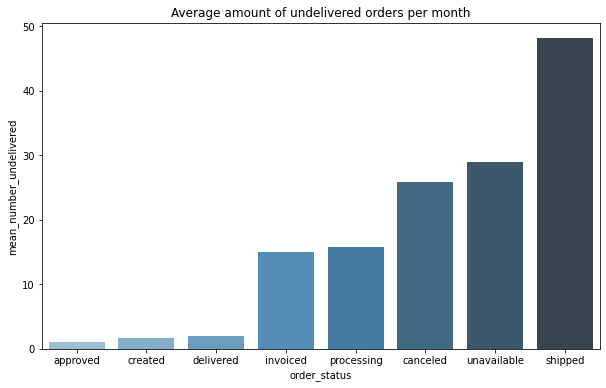

In [57]:
plt.figure(figsize=(10, 6))
sns.barplot(x='order_status', y='mean_number_undelivered', data=undelivered_df, palette="Blues_d").set(title='Average amount of undelivered orders per month') 

Таким образом, в среднем наибольшее количество заказов в месяц не доставляется по причине того, что эти заказы отгружены со склада и все еще находятся в пути. 
На втором месте по количеству недоставленных заказов находятся unavailable заказы, на третьем - отмененные заказы.

**Вопрос 3. По каждому товару определить, в какой день недели товар чаще всего покупается.** 

In [58]:
# Объединим таблицы с заказами и таблицу с товарами
orders_and_items = orders.merge(items, on='order_id', how = 'left')

In [59]:
# Добавим столбец с днём недели, в который был сделан заказ

In [60]:
orders_and_items["order_day"] = orders_and_items["order_purchase_timestamp"].dt.day_name()

Учитываем, что под покупкой подразумевается доставленный товар (т.е. имеющий статус delivered и указанную дату доставки). 

In [61]:
delivered_items_orders = orders_and_items.query('order_status == "delivered" and order_delivered_customer_date != "NaT"') 

In [62]:
delivered_items_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday


Сгруппируем полученные данные по product_id и order_day и посчитаем, сколько было сделано покупок каждого товара по дням недели.

In [63]:
delivered_items_orders_group = delivered_items_orders.groupby(['product_id', 'order_day'], as_index = False) \
                       .agg({'order_id' : 'count'}) \
                       .rename(columns = {'order_id' : 'number_orders'})\
                       .sort_values(['product_id', 'number_orders'], ascending = False)

In [64]:
delivered_items_orders_group

,product_id,order_day,number_orders
59948,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
59947,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2
59944,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
59945,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
59946,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
...,...,...,...
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1


У какого-то товара могут быть разные дни недели с одинаковым количеством покупок.
Возможна ситуация, например, когда каждый товар куплен по одному разу каждый день, тогда какой день будет являться днем с максимальным количеством покупок?

In [65]:
# пример товара, купленного одинаковое наибольшее количество раз в среду и четверг

example_product = delivered_items_orders_group.query('product_id == "4244733e06e7ecb4970a6e2683c13e61"')

In [66]:
example_product

,product_id,order_day,number_orders
15628,4244733e06e7ecb4970a6e2683c13e61,Thursday,2
15630,4244733e06e7ecb4970a6e2683c13e61,Wednesday,2
15624,4244733e06e7ecb4970a6e2683c13e61,Friday,1
15625,4244733e06e7ecb4970a6e2683c13e61,Monday,1
15626,4244733e06e7ecb4970a6e2683c13e61,Saturday,1
15627,4244733e06e7ecb4970a6e2683c13e61,Sunday,1
15629,4244733e06e7ecb4970a6e2683c13e61,Tuesday,1


Для итогового вывода сгруппируем данные таким образом, чтобы для товаров, купленных одинаковое наибольшее количество раз в разные дни, эти дни выводились в одной ячейке таблицы.

In [67]:
result_days = delivered_items_orders_group.groupby(['product_id', 'number_orders'], as_index = False) \
                       .agg({'order_day' : 'sum'}) \
                       .sort_values(['product_id', 'number_orders'], ascending = False) \
                       .groupby(['product_id'], as_index = False) \
                       .agg({'number_orders' : 'max', 'order_day' : 'first'}) \
                       .rename(columns = {'order_day' : 'max_orders_days'})

In [68]:
result_days # итоговая выборка с указанием дней, в которые чаще всего покупается товар

,product_id,number_orders,max_orders_days
0,00066f42aeeb9f3007548bb9d3f33c38,1,Sunday
1,00088930e925c41fd95ebfe695fd2655,1,Tuesday
2,0009406fd7479715e4bef61dd91f2462,1,Thursday
3,000b8f95fcb9e0096488278317764d19,1,FridayWednesday
4,000d9be29b5207b54e86aa1b1ac54872,1,Tuesday
...,...,...,...
32209,fff6177642830a9a94a0f2cba5e476d1,1,SaturdaySunday
32210,fff81cc3158d2725c0655ab9ba0f712c,1,Monday
32211,fff9553ac224cec9d15d49f5a263411f,1,Friday
32212,fffdb2d0ec8d6a61f0a0a0db3f25b441,2,Tuesday


In [69]:
# Проверим выборку на том же товаре
example_product_2 = result_days.query('product_id == "4244733e06e7ecb4970a6e2683c13e61"') 

In [70]:
example_product_2

,product_id,number_orders,max_orders_days
8442,4244733e06e7ecb4970a6e2683c13e61,2,ThursdayWednesday


**Вопрос 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?**

У нас уже есть датафрэйм, где одновременно есть информация о пользователях и их покупках. Из этого датафрэйма отберем данные, которые мы считаем покупкой. Добавим столбец с названием месяца и столбец с количеством дней в месяце

In [71]:
weekly_customers = orders_and_items.query('order_status == "delivered" and order_delivered_customer_date != "NaT"')

In [72]:
weekly_customers["order_month"] = pd.DatetimeIndex(weekly_customers["order_purchase_timestamp"]).month_name()


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
weekly_customers["days_in_month"] = weekly_customers['order_purchase_timestamp'].dt.days_in_month

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
weekly_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_day,days_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,October,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday,31
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,July,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Tuesday,31
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,August,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday,31
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,November,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday,30
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,February,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday,28


Сгруппируем данные по пользователям и месяцам и рассчитаем количество заказов в месяц.

In [75]:
weekly_customers_group = weekly_customers.groupby(['customer_id', 'order_month'], as_index = False) \
                       .agg({'order_id' : 'nunique', 'days_in_month' : 'mean'})\
                       .rename(columns = {'order_id' : 'number_orders'}) \
                       .sort_values(['number_orders'], ascending = False)

In [76]:
weekly_customers_group.sort_values('number_orders', ascending = False).head()

,customer_id,order_month,number_orders,days_in_month
0,00012a2ce6f8dcda20d059ce98491703,November,1,30
13,00072d033fe2e59061ae5c3aff1a2be5,September,1,30
4,000379cdec625522490c315e70c7a9fb,April,1,30
5,0004164d20a9e969af783496f3408652,April,1,30
6,000419c5494106c306a97b5635748086,March,1,31


Добавим столбец, в котором рассчитывается среднее количество покупок в неделю для каждого пользователя (по месяцам)

In [77]:
weekly_customers_group['weekly_purchases'] = weekly_customers_group.number_orders / (weekly_customers_group.days_in_month / 7)

In [78]:
weekly_customers_group[['customer_id', 'order_month', 'weekly_purchases']]

,customer_id,order_month,weekly_purchases
0,00012a2ce6f8dcda20d059ce98491703,November,0.233333
64310,aa5dfb0872b3828aa250acb54d387266,June,0.233333
64319,aa606152f23a5fa9ba3d0b87f7a492e8,January,0.225806
64318,aa601b3c45980c0918042d5ca7a25054,March,0.225806
64317,aa5f8aa4c21fe89a04e8d221d4cd8ac1,August,0.225806
...,...,...,...
32154,5584b1ace8b18cc156ce51b989fd2958,May,0.225806
32153,558499c2027ec01d530fb975ce2e5b2f,April,0.233333
32152,55846a9bb9076de56da44e430349ad1a,April,0.233333
32151,55840ff4caf1d80ac296d0b1ac968b53,May,0.225806


**Вопрос 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.**

Перед проведением когортного анализа определяют четыре параметра:

Признак формирования когорты — действие, которое объединяет людей в группу: первый заказ

Размер когорты — временной интервал: месяц

Отчетный период — время исследования поведения групп: период с января по декабрь.

Анализируемый ключевой показатель: Retention Rate

Для расчета retention будем рассматривать не факт покупки, а факт создания заказа, так как это является признаком возврата клиента в магазин. С этой точки зрения нам не важно, состоялась ли доставка или была отмена заказа. 

Нужно провести анализ за период с января по декабрь. Данные о клиентах и их заказах есть в объединенной таблице. В исходном датафрэйме содержатся данные о заказах, сделанных в период с сентября 2016 по сентябрь 2018 г. Т. е. если нам нужен анализ за один полный год, то нужно отобрать данные о заказах с 1 января 2017 по 31 декабря 2017 г.

In [79]:
customers_cohort = customers.merge(orders, on='customer_id', how='left')

In [80]:
# статистика по столбцу с датой заказа
customers_cohort['order_purchase_timestamp'].describe(datetime_is_numeric=True)

count                            99441
mean     2017-12-31 08:43:12.776581120
min                2016-09-04 21:15:19
25%                2017-09-12 14:46:19
50%                2018-01-18 23:04:36
75%                2018-05-04 15:42:16
max                2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: object

In [81]:
# отбираем нужный период для анализа

sample = customers_cohort.query("'2017-01-01' <= order_purchase_timestamp <= '2017-12-31'") 

Отбираем данные о пользователях и дате их первой покупки

In [82]:
first_purchase = sample.groupby('customer_unique_id', as_index = False) \
                          .agg({'order_purchase_timestamp' : 'min'})

Добавим колонку с номером месяца, когда была сделана первая покупка. Этот номер также будет являться номером когорты.

In [83]:
first_purchase["cohort_period"] = pd.DatetimeIndex(first_purchase["order_purchase_timestamp"]).month

In [84]:
first_purchase.head()

,customer_unique_id,order_purchase_timestamp,cohort_period
0,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,3
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,10
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:32:12,3
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18 09:23:10,7


In [85]:
# объединим столбец с месяцем первой покупки с основным датафрэймом

cohort = sample.merge(first_purchase, on = 'customer_unique_id', how = 'left')

In [86]:
cohort.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp_x,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,order_purchase_timestamp_y,cohort_period
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05-16 15:05:35,5
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09,2017-09-14 18:14:31,9
2,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2017-11,2017-11-16 19:29:02,11
3,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,2017-11,2017-11-27 17:23:20,11
4,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,2017-09,2017-09-09 09:54:57,9


In [87]:
cohort["order_month"] = cohort["order_purchase_timestamp_x"].dt.to_period("M") # добавляем столбец с месяцем заказов

In [88]:
cohort.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp_x,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,order_purchase_timestamp_y,cohort_period
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05-16 15:05:35,5
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2017-09-14 18:14:31,2017-09-14 18:25:11,2017-09-18 21:27:40,2017-09-28 17:32:43,2017-10-04,2017-09,2017-09-14 18:14:31,9
2,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG,1093c8304c7a003280dd34598194913d,delivered,2017-11-16 19:29:02,2017-11-16 19:55:41,2017-11-22 16:46:33,2017-11-27 12:44:36,2017-12-08,2017-11,2017-11-16 19:29:02,11
3,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,39400,montes claros,MG,8428e578bb1cf839ae26a6b7615502b9,delivered,2017-11-27 17:23:20,2017-11-27 18:01:20,2017-11-28 23:04:41,2017-12-08 22:16:17,2017-12-20,2017-11,2017-11-27 17:23:20,11
4,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,18682,lencois paulista,SP,83d8f70418eefd96f37b483dff430305,delivered,2017-09-09 09:54:57,2017-09-09 10:10:17,2017-09-12 12:42:43,2017-09-20 20:23:34,2017-10-02,2017-09,2017-09-09 09:54:57,9


Группируем данные по месяцу первой покупки и месяцу других покупок, считаем уникальных пользователей

In [89]:
cohort_group = cohort.groupby(['cohort_period', 'order_month'], as_index = False) \
                     .agg({'customer_unique_id' : pd.Series.nunique}) \
                     .sort_values(['cohort_period', 'order_month']) \
                     .rename(columns = {'customer_unique_id' : 'number_users'})

In [90]:
cohort_group.head()

,cohort_period,order_month,number_users
0,1,2017-01,765
1,1,2017-02,3
2,1,2017-03,2
3,1,2017-04,1
4,1,2017-05,3


In [91]:
# в первый месяц для каждой когорты количество заказов максимально. Создадим отдельный столбец с этими значениями

first_purchase_sum = cohort_group.groupby('cohort_period', as_index = False) \
                                 .agg({'number_users' : max}) \
                                 .rename(columns = {'number_users' : 'first_month_orders'})

In [92]:
first_purchase_sum

,cohort_period,first_month_orders
0,1,765
1,2,1752
2,3,2636
3,4,2353
4,5,3596
5,6,3139
6,7,3895
7,8,4184
8,9,4131
9,10,4470


In [93]:
# объединим данные с количеством заказов в первый месяц для каждой когорты с основным датафрэймом

cohort_group_merged = cohort_group.merge(first_purchase_sum, on = 'cohort_period', how = 'left')

In [94]:
cohort_group_merged

,cohort_period,order_month,number_users,first_month_orders
0,1,2017-01,765,765
1,1,2017-02,3,765
2,1,2017-03,2,765
3,1,2017-04,1,765
4,1,2017-05,3,765
...,...,...,...,...
72,10,2017-11,31,4470
73,10,2017-12,11,4470
74,11,2017-11,7305,7305
75,11,2017-12,40,7305


In [95]:
# добавим столбец, в котором рассчитан показатель retention

cohort_group_merged['cohort_group_retention'] = round(cohort_group_merged.number_users / cohort_group_merged.first_month_orders, 4)

In [96]:
cohort_group_merged

,cohort_period,order_month,number_users,first_month_orders,cohort_group_retention
0,1,2017-01,765,765,1.0000
1,1,2017-02,3,765,0.0039
2,1,2017-03,2,765,0.0026
3,1,2017-04,1,765,0.0013
4,1,2017-05,3,765,0.0039
...,...,...,...,...,...
72,10,2017-11,31,4470,0.0069
73,10,2017-12,11,4470,0.0025
74,11,2017-11,7305,7305,1.0000
75,11,2017-12,40,7305,0.0055


In [97]:
# итоговый датафрэйм с показателями retention по когортам

cohort_group_pivot = cohort_group_merged.pivot(index='cohort_period', columns='order_month', values='cohort_group_retention')

In [98]:
cohort_group_pivot

order_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_period,,,,,,,,,,,,
1,1.0,0.0039,0.0026,0.0013,0.0039,0.0013,0.0052,0.0013,0.0013,NaN,0.0039,0.0013
2,NaN,1.0000,0.0023,0.0029,0.0011,0.0040,0.0011,0.0023,0.0017,0.0017,0.0023,0.0011
3,NaN,NaN,1.0000,0.0049,0.0038,0.0038,0.0034,0.0015,0.0015,0.0030,0.0034,0.0008
4,NaN,NaN,NaN,1.0000,0.0059,0.0021,0.0017,0.0034,0.0025,0.0034,0.0030,0.0030
5,NaN,NaN,NaN,NaN,1.0000,0.0050,0.0050,0.0039,0.0031,0.0033,0.0042,0.0017
6,NaN,NaN,NaN,NaN,NaN,1.0000,0.0048,0.0035,0.0041,0.0025,0.0038,0.0038
7,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.0051,0.0036,0.0026,0.0028,0.0021
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.0069,0.0033,0.0026,0.0036
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.0068,0.0053,0.0027


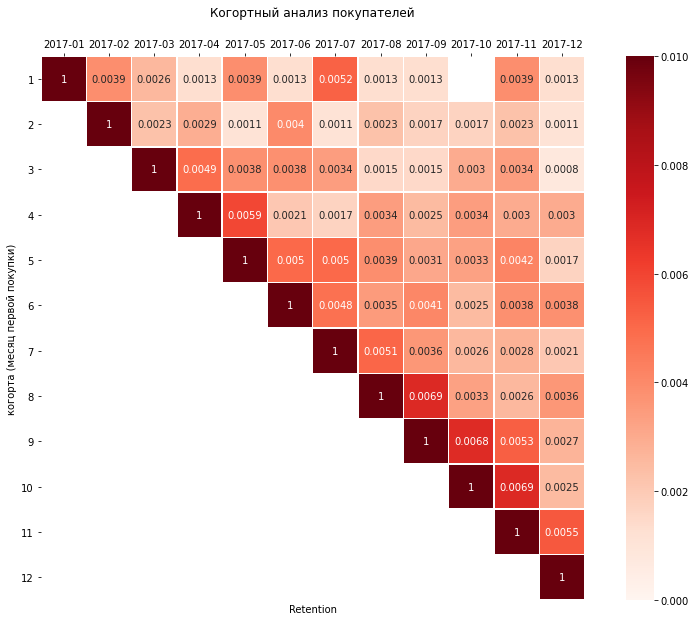

In [99]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(cohort_group_pivot, annot=True, linewidths=0.5,square=True, cmap='Reds', vmin=0, vmax=0.01) 
ax.xaxis.tick_top()
plt.xlabel('Retention')
plt.ylabel('когорта (месяц первой покупки)')
plt.title('Когортный анализ покупателей',pad=40)
plt.yticks(rotation = 0)
plt.show()

Наибольшее значение retention на 3-й месяц у когорты 6 (0,0041)

**Вопрос 6. Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.**

R - время от последней покупки пользователя до текущей даты 

F - суммарное количество покупок у пользователя за всё время, 

M - сумма покупок за всё время.

Сделаем выборку данных для анализа.  Под покупкой в данном случае подразумеваются заказы, имеющие статус delivered и имеющие зафиксированную дату доставки, т.е. будем рассматривать только завершенные кейсы. Заказы, которые были отменены, не принесли нам денег. Заказы, которые еще не доставлены, теоретически могут никогда не быть доставленными, их считаем спорными и тоже не рассматриваем. <br> Так как в таблице для каждого заказа есть только перечень купленных товаров их цена, но нет общей суммы по каждому заказу, то нужно сгруппировать данные по пользователям и заказам

In [100]:
merged_orders_items = orders.merge(items, on = 'order_id', how = 'inner')

In [101]:
merged_orders_items_customers = merged_orders_items.merge(customers, on = 'customer_id', how = 'inner')

In [102]:
complete_orders = merged_orders_items_customers.query('order_status == "delivered" and order_delivered_customer_date != "NaT"')\
                  .groupby(['customer_unique_id', 'customer_id', 'order_id', 'order_purchase_timestamp'], as_index = False) \
                  .agg({'price' : 'sum'}) \
                  .rename(columns = {'price' : 'order_sum'})

In [103]:
complete_orders

,customer_unique_id,customer_id,order_id,order_purchase_timestamp,order_sum
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.90
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,25.99
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,180.00
...,...,...,...,...,...
96465,fffcf5a5ff07b0908bd4e2dbc735a684,74be082247cd677a147d83ee670e9d53,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08 21:00:36,1570.00
96466,fffea47cd6d3cc0a88bd621562a9d061,0ecf8e0a08148af0bf313184f167670a,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,64.89
96467,ffff371b4d645b6ecea244b27531430a,27f584b0f1dc4e610065c240f68b6be0,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07 15:49:16,89.90
96468,ffff5962728ec6157033ef9805bacc48,832a3b0254347d409512ae92eaf154a6,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-02 15:17:41,115.00


In [104]:
#Временной промежуток, в который были сделаны заказы, составляет 2 года - с сентября 2016 по август 2018 г.

complete_orders['order_purchase_timestamp'].describe(datetime_is_numeric=True)

count                            96470
mean     2018-01-01 23:17:43.624411904
min                2016-09-15 12:16:38
25%         2017-09-14 08:56:46.500000
50%         2018-01-20 19:34:43.500000
75%      2018-05-05 18:29:50.249999872
max                2018-08-29 15:00:37
Name: order_purchase_timestamp, dtype: object

Так как имеющийся набор данных не актуальный, то в качестве текущей даты выбран следующий день после самой последней покупки, т.е. 2018-08-30.

In [105]:
now = complete_orders['order_purchase_timestamp'].max() + timedelta(days=1)

In [106]:
now

Timestamp('2018-08-30 15:00:37')

Добавляем колонку с количеством дней от даты покупки до текущей даты

In [107]:
complete_orders['days_since_order'] = (now - complete_orders.order_purchase_timestamp).dt.days

In [108]:
complete_orders

,customer_unique_id,customer_id,order_id,order_purchase_timestamp,order_sum,days_since_order
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.90,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.90,115
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,69.00,537
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,25.99,321
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,180.00,288
...,...,...,...,...,...,...
96465,fffcf5a5ff07b0908bd4e2dbc735a684,74be082247cd677a147d83ee670e9d53,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08 21:00:36,1570.00,447
96466,fffea47cd6d3cc0a88bd621562a9d061,0ecf8e0a08148af0bf313184f167670a,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,64.89,262
96467,ffff371b4d645b6ecea244b27531430a,27f584b0f1dc4e610065c240f68b6be0,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07 15:49:16,89.90,568
96468,ffff5962728ec6157033ef9805bacc48,832a3b0254347d409512ae92eaf154a6,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-02 15:17:41,115.00,119


Еще раз сгруппируем данные, чтобы получить итоговые значения recency, frequency и monetary_value для каждого уникального покупателя

In [109]:
res = complete_orders.groupby(['customer_unique_id'], as_index = False) \
                  .agg({'days_since_order': 'min', 'order_id': 'count', 'order_sum' : 'sum'}) \
                  .rename(columns = {'days_since_order': 'recency', 'order_id': 'frequency', 'order_sum' : 'monetary_value'})

In [110]:
res

,customer_unique_id,recency,frequency,monetary_value
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93345,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00
93346,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93347,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93348,ffff5962728ec6157033ef9805bacc48,119,1,115.00


Далее, зная значения recency, frequency и monetary_value, нужно определить диапазоны ранжирования показателей и выставить оценки для каждого пользователя. Будем использовать 3-балльную шкалу для каждого показателя. Для определения границ диапазонов будем учитывать описательную статистику

In [111]:
res.describe()

,recency,frequency,monetary_value
count,93350.000000,93350.000000,93350.000000
mean,237.950070,1.033423,141.620235
std,152.589932,0.209106,215.702028
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.700000
75%,346.000000,1.000000,154.697500
max,714.000000,15.000000,13440.000000


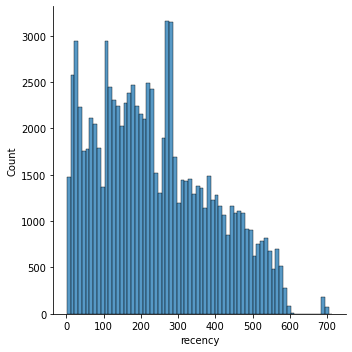

In [112]:
sns.displot(res["recency"])

**recency**</p> 
<p>Половина заказов была сделана не более 219 дней назад от текущей даты. Еще 25% - в период от 219 до 346 дней. Тогда по показателю recency примем следующие группы (в порядке убывания значимости):</p> 
<p>1 - значения за период от 0 до 219 дней (50% пользователей, покупали недавно)</p>
<p>2 - значения за период от 220 до 346 дней (25% пользователей, покупали давно)</p>
<p>3 - оствшиеся значения от 347 дней (25% пользователей, покупали очень давно)</p>

**frequency**</p> 
Подавляющее число пользователей совершили только одну покупку

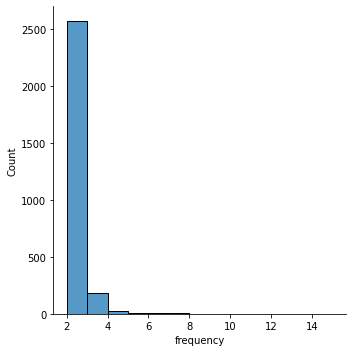

In [113]:
sns.displot(res.query('frequency != "1"').frequency)

Если не рассматривать тех, кто сделал только одну покупку, на втором месте по количеству покупок клиенты с покупками от 2 до 4 раз. Максимальное количество покупок у пользователя - 15. 
<p>Тогда по показателю frequency примем следующие группы (в порядке убывания значимости):</p> 
<p>1 - пользователи, совершившие от 5 до 15 покупок</p> 
<p>2 - пользователи, совершившие от 2 до 4 покупок</p> 
<p>3 - пользователи, совершившие 1 покупку</p> 

**monetary value**</p> 
<p>Половина покупок пользователей по сумме не превышает 89,7 денежных единиц. Так как по сумме чеков есть существенные выбросы, то медиана будет предпочтительнее среднего значения. 

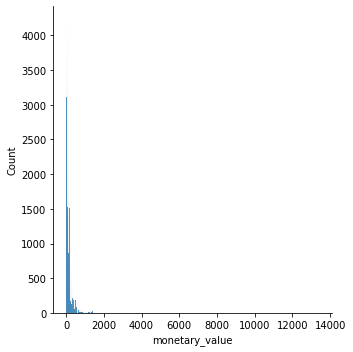

In [114]:
# график по всем значениям малоинформативен из-за наличия нетипично больших значений суммы покупок
sns.displot(res["monetary_value"])

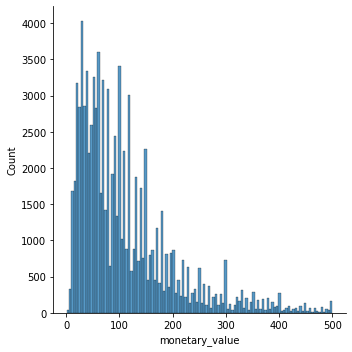

In [115]:
# пользователи с суммой чека меньше 500 денежных единиц
sns.displot(res.query('monetary_value < 500').monetary_value)

Так как основная масса чеков по сумме не превышает 200 денежных единиц, то, вероятнее всего, дорогостоящие товары не являются основой продаж в этом магазине. Больше всего магазин заинтересован в тех пользователях, кто тратит максимально большие суммы, но их количество, как правило, меньше, чем покупателей с маленьким чеком. 
Тогда по показателю monetary_value примем следующие группы (в порядке убывания значимости):</p> 
<p>1 - сумма от 154,6975 ден. ед. (верхние 25% пользователей по сумме чека)</p>
<p>2 - сумма от 47,65 до 154,6975 ден. ед. (50% пользователей, наиболее типичные, основная масса)</p>    
<p>3 - минимальные значения с суммой от 0 до 47,65 ден. ед. (25% пользователей, тратят меньше всего)</p>

In [116]:
def RScore(x):
     if x <= 219:
         return 1
     elif x > 219 and x <= 346:
         return 2
     elif x > 346: 
         return 3

In [117]:
def FScore(x):
     if x >= 5:
         return 1
     elif x >= 2 and x < 5:
         return 2
     elif x < 2: 
         return 3

In [118]:
def MScore(x):
     if x >= 154.6975:
         return 1
     elif x >= 47.65 and x < 154.6975:
         return 2
     elif x < 47.65: 
         return 3

In [119]:
res['R'] = res['recency'].apply(RScore)
res['F'] = res['frequency'].apply(FScore)
res['M'] = res['monetary_value'].apply(MScore)

In [120]:
res.head()

,customer_unique_id,recency,frequency,monetary_value,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,3,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,1,3,3
2,0000f46a3911fa3c0805444483337064,537,1,69.00,3,3,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,3,3
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,3,1


In [121]:
# Добавим столбец с показателем RFM для каждого пользователя.

res['RFM_score'] = res['R'].map(str) + res['F'].map(str) + res['M'].map(str)

In [122]:
res.head()

,customer_unique_id,recency,frequency,monetary_value,R,F,M,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,3,2,132
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,1,3,3,133
2,0000f46a3911fa3c0805444483337064,537,1,69.00,3,3,2,332
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,3,3,233
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,3,1,231


In [123]:
# сгруппируем данные по сегментам, чтобы посмотреть количество покупателей в каждом сегменте

res_group = res.groupby('RFM_score', as_index = False) \
               .agg({'customer_unique_id': 'count'}) \
               .rename(columns = {'customer_unique_id': 'number_of_clients'})

In [124]:
res_group

,RFM_score,number_of_clients
0,111,17
1,121,952
2,122,528
3,123,52
4,131,10758
5,132,22859
6,133,11675
7,211,1
8,221,396
9,222,261


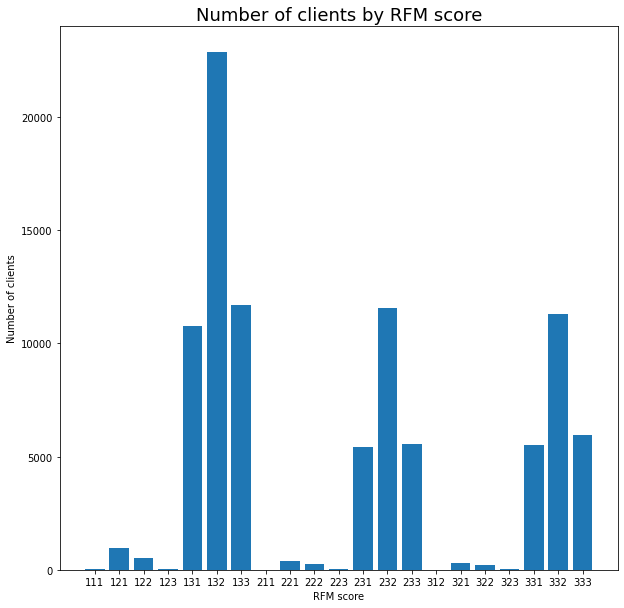

In [125]:
plt.figure(figsize=(10,10))
plt.bar(res_group.RFM_score, res_group.number_of_clients)
plt.title('Number of clients by RFM score', fontsize=18)
plt.ylabel('Number of clients')
plt.xlabel('RFM score')
plt.show()

В теории у нас должно быть 27 различных сегментов покупателей. Но в представленных данных покупатели поделились на 21 сегмент.

1	111 — недавние частые с высоким чеком<br>
2	112 — недавние частые со средним чеком (нет)<br>
3	113 — недавние частые с низким чеком (нет)<br>
4	121 — недавние редкие с высоким чеком<br>
5	122 — недавние редкие со средним чеком<br>
6	123 — недавние редкие с низким чеком<br>
7	131 — недавние разовые с высоким чеком<br>
8	132 — недавние разовые со средним чеком<br>
9	133 — недавние разовые с низким чеком<br>
10	211 — спящие частые с высоким чеком<br>
11	212 — спящие частые со средним чеком (нет)<br>
12	213 — спящие частые с низким чеком<br>
13	221 — спящие редкие с высоким чеком<br>
14	222 — спящие редкие со средним чеком<br>
15	223 — спящие редкие с низким чеком<br>
16	231 — спящие разовые с высоким чеком<br>
17	232 — спящие разовые со средним чеком<br>
18	233 — спящие разовые с низким чеком<br>
19	311 — давние частые с высоким чеком (нет)<br>
20	312 — давние частые со средним чеком<br>
21	313 — давние частые с низким чеком (нет)<br>
22	321 — давние редкие с высоким чеком (нет)<br>
23	322 — давние редкие со средним чеком<br>
24	323 — давние редкие с низким чеком<br>
25	331 — давние разовые с высоким чеком<br>
26	332 — давние разовые со средним чеком<br>
27	333 — давние разовые с низким чеком<br>

Больше всего покупателей относятся к сегменту 132 -  недавние покупатели, совершившие покупку в течение последних 219 дней, покупка разовая, со средним чеком из диапазона от 47,65 до 154,6975 ден. ед.<br>
На втором месте примерно в равных долях находятся покупатели в сегментах: <br>
 131	— недавние разовые с высоким чеком<br>
 133	— недавние разовые с низким чеком<br>
 232	— спящие разовые со средним чеком<br>
 332	— давние разовые со средним чеком<br>
 Мы не знаем, что за товары продаются в магазине, возможно это что-то, что не нужно повторно покупать в короткое время. Тогда менеджменту магазина в первую очередь нужно работать над увеличением суммы чека. В обратном случае, нужно более активно стимулировать покупателей для повторной покупки.